## OpenCV Affine and Perspective Transformation

### Reference:
Tutorial: <br>
https://docs.opencv.org/master/da/d6e/tutorial_py_geometric_transformations.html <br>
Document:<br>
https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983


###  從Darknet中預測四個校正點

In [2]:
from darknet import load_network, print_detections, decode_detection, detect_image
from darknet_images import *
from darknet_video import *
import cv2
from matplotlib import pyplot as plt

cfg_path = ".\\cfg\\yolov4-tiny-dart.cfg"
data_path = ".\\cfg\\dart_local.data"
weights_path =".\\backup_weight\\yolov4-tiny-dart_final.weights"

# load network
network, class_names, class_colors = darknet.load_network(
            cfg_path,
            data_path,
            weights_path,
            batch_size=1
        )

Run: darknet_images.py or:

python.exe darknet_video.py --data_file cfg/coco.data --config_file cfg/yolov4.cfg --weights yolov4.weights --input test.mp4 

name 'DARKNET_FORCE_CPU' is not defined


In [79]:
image_path = r"..\\images\cropped\crop_PXL_20220224_134807891.jpg"
# image_path = r"..\\images\cropped\crop_PXL_20220302_134930321.jpg"
# image_path = r"..\\images\cropped\crop_PXL_20220302_134155426.jpg"
image_std_path = r"..\\dartboard.jpg"

# dart detection
image, detections = image_detection(
            image_path, network, class_names, class_colors, 0.5
)

# draw dartboard scoring region lines 
calibratePoints_std = {"topP": (262,49), "bottomP": (204,411), "leftP": (53,196), "rightP": (417, 255)}
detectedPoints = {}
dartPoints = []
for d in detections:
    if d[0] == 'topP': detectedPoints['topP'] = tuple(int(i) for i in d[2][:2])
    elif d[0] == 'bottomP': detectedPoints['bottomP'] = tuple(int(i) for i in d[2][:2])
    elif d[0] == 'leftP': detectedPoints['leftP'] = tuple(int(i) for i in d[2][:2])
    elif d[0] == 'rightP': detectedPoints['rightP'] = tuple(int(i) for i in d[2][:2])
    elif d[0] == 'dartP': dartPoints.append(['dartP', tuple(int(i) for i in d[2][:2])])

print(detectedPoints)
print(calibratePoints_std)
print(dartPoints)
# 顯示std結果圖
# img_std = cv2.imread(image_std_path)
# img_std = cv2.cvtColor(img_std, cv2.COLOR_BGR2RGB)
# for p in calibratePoints_std.values(): cv2.circle(img_std, tuple([int(i) for i in p]), 2, (0,255,0), 2)
# plt.imshow(img_std),plt.title('img_std')
# plt.show()

{'rightP': (320, 201), 'bottomP': (160, 323), 'topP': (202, 53), 'leftP': (59, 172)}
{'topP': (262, 49), 'bottomP': (204, 411), 'leftP': (53, 196), 'rightP': (417, 255)}
[['dartP', (222, 290)], ['dartP', (240, 83)]]


### 計算透視轉換矩陣

In [80]:
# read image
img = cv2.imread(image_path)
img = cv2.resize(img, (416,416))
img_std = cv2.imread(image_std_path)
rows,cols,ch = img.shape
pts_std = np.float32(list(calibratePoints_std.values()))
pts = np.float32([detectedPoints['topP'], detectedPoints['bottomP'], detectedPoints['leftP'], detectedPoints['rightP']])
plt.subplot(132),plt.imshow(img),plt.title('img')

(<AxesSubplot:title={'center':'img'}>,
 Text(0.5, 1.0, 'img'))

### 使用sift計算透視轉換矩陣

### 使用校正點計算透視轉換矩陣 - Perspective Transformation 透視變換

good_matches size: 142
src_pts's shape: (142, 1, 2)


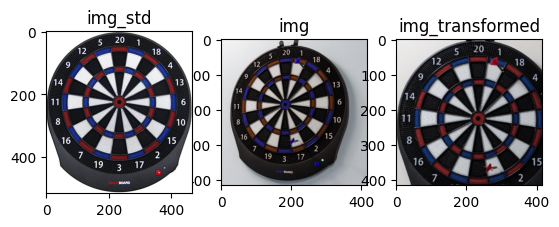

In [81]:
# 使用sift搜尋特徵點和描述子 
'''
 - cv2.SIFT()
 - SIFT.detectAncCompute()
'''
def getPerspectiveTransformbySIFT(img_std, img):
    MAX_NUM_FEARTURES = 1000
    sift_detector = cv2.SIFT_create(MAX_NUM_FEARTURES)
    keypoint1, descriptor1 = sift_detector.detectAndCompute(img_std, None)
    keypoint2, descriptor2 = sift_detector.detectAndCompute(img, None)

    # 使用FLANN 特徵匹配演算法 
    # 設定FLANN參數
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # 使用FLANN matcher尋找匹配
    flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann_matcher.knnMatch(descriptor1,descriptor2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance: # m,n前2與原圖間歐式距離最相近的匹配點, 若m/n小於一定比率,則m匹配的越準確
            good_matches.append(m)

    print("good_matches size:", len(good_matches))


    MIN_MATCH_COUNT = 10
    if len(good_matches)>MIN_MATCH_COUNT:
        # 整理匹配點座標
        src_pts = np.float32([ keypoint1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)    # 原圖關鍵點座標
        dst_pts = np.float32([ keypoint2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)    # 目標圖關鍵點座標
        print("src_pts's shape:", src_pts.shape)
        '''
        m 的型別為DMatch
        DMatch.queryIdx 指的是原圖關鍵點在keypoint1中的index
        DMatch.trainIdx 指的是目標圖圖關鍵點在keypoint2中的index
        https://stackoverflow.com/questions/13318853/opencv-drawmatches-queryidx-and-trainidx
        '''

        # 找出透視轉換矩陣
        M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0) # M: homography matrix
        return M
    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        matchesMask = None


# 使用sift找出透視轉換矩陣
M = getPerspectiveTransformbySIFT(img_std, img)
img = cv2.warpPerspective(img, M, (cols,rows))

# 使用4個校正點找出透視轉換矩陣
# M = cv2.getPerspectiveTransform(pts,pts_std)
# img = cv2.warpPerspective(img,M,(cols,rows))

# # 顯示結果圖
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_std = cv2.cvtColor(img_std, cv2.COLOR_BGR2RGB)
plt.subplot(131),plt.imshow(img_std),plt.title('img_std')
plt.subplot(133),plt.imshow(img),plt.title('img_transformed')
plt.show()

###  計算得分區域 scoring area 

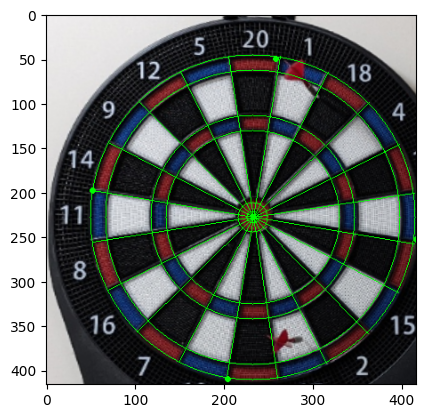

In [82]:
# draw scoring area lines 
# find calibrated points from pts to dst
import numpy as np
pts = np.float32(pts).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)
for p in dst[:,0,:]:
    cv2.circle(img, tuple([int(i) for i in p]), 2, (0,255,0), 2)

# calculate scoring region
# find center point 
def line_intersection(line1, line2):
    # https://stackoverflow.com/a/20677983
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

tp, bp, lp, rp = dst[:,0,:]
center = ((tp[0]+bp[0]+lp[0]+rp[0])/4, (tp[1]+bp[1]+lp[1]+rp[1])/4) # find center just by averaging 4 points
# line1 = [tp, bp]
# line2 = [lp, rp]
# center = line_intersection(line1, line2)  # find center by getting intersection point
cv2.circle(img, (round(center[0]), round(center[1])), 2, (0,255,0), 2)

# find radius R by averaging 4 distances from center point to calibrate points 
def dist(p1, p2): return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5
def polar2xy(center, r, theta):
    return (round(center[0] + r*np.cos(theta*np.pi/180.0-90)), round(center[1] + r*np.sin(theta*np.pi/180.0-90)))

Rscale = [i/340 for i in [12.7, 32, 182, 214, 308,  340]]
R = (dist(center, tp)+dist(center, bp)+dist(center, lp)+dist(center, rp))/4 
for ratio in Rscale:
    cv2.circle(img, (int(center[0]), int(center[1])), round(R*ratio), (0,255,0), 1)
for d in range(18, 378, 18):
    cv2.line(img, (round(center[0]), round(center[1])), tuple(polar2xy(center, R, d)), (0,255,0), 1)

plt.imshow(img)
plt.show()

### 計算落鏢點得分

-13658.551105868013
149.4667253001097
-10411.117438312096
21.995253244826767


<ipython-input-83-0ced16a17b90>:22: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(img, str(score), tuple(pos), 0, 0.7, (255, 0, 0), 2)


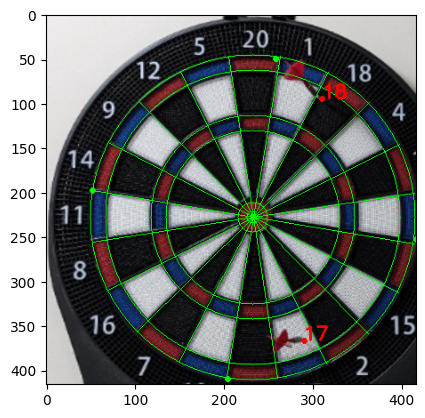

In [83]:
if dartPoints:
    dartPoints = np.float32([i[1] for i in dartPoints]).reshape(-1, 1, 2)
    dartPoints = cv2.perspectiveTransform(dartPoints, M).reshape(-1,2)
    scoreMap = {0:1,1:18,2:4,3:13,4:6,5:10,6:15,7:2,8:17,9:3,10:19,11:7,12:16,13:8,14:11,15:14,16:9,17:12,18:5,19:20}
    v0 = [tp[0]-center[0],tp[1]-center[1]]    # vector from center to topP
    d0 = np.linalg.norm(v0)
    for pos in dartPoints:
        # calculate score
        vdart = [pos[0]-center[0],pos[1]-center[1]] # vector from center to dart
        ddart = np.linalg.norm(vdart)
        dot = np.dot(v0, vdart)
        cross = np.cross(vdart, v0)
        print(cross)
        if cross > 0: theta = 360-np.arccos(dot/(d0*ddart))/np.pi*180
        else: theta = np.arccos(dot/(d0*ddart))/np.pi*180
        print(theta)
        score = scoreMap[round(theta/18)]

        # draw dart point
        cv2.circle(img, (round(pos[0]), round(pos[1])), 2, (255,0,0), 2)
        # put score text
        cv2.putText(img, str(score), tuple(pos), 0, 0.7, (255, 0, 0), 2)

    plt.imshow(img)
    plt.show()
else:
    print("No darts detecred!")